In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from scipy import special, integrate
import os
import sys

sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools

### covariance of the 3D 2pcf

Eq. 12 in Heitmann et al. (2021): https://ui.adsabs.harvard.edu/abs/2021ApJS..252...19H/abstract *

$$
C_\xi(r,r')=\int\frac{k^2\mathrm{d}k}{2\pi^2}j_0(kr)\,j_0(kr')\,\sigma^2_P(k) ~,
$$

where $\sigma_P$ is the shot noise component:
$$
\sigma^2_P = \frac{2}{V}\left(P(k)+\frac{1}{\bar n}\right)^2 ~,
$$
$P(k)$ is the matter power spectrum (?), $V$ is the simulation volume, and $\bar n$ is the mean tracer number density.

Then the standard deviation of the 2pcf is just
$$
\sigma_\xi(r) = \sqrt{C_\xi(r,r')}
$$

\* also cites Cohn (2006) and Smith et al. (2008)

In [3]:
# initialize simulation
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)

# define conversions
def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift)
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift)

# comoving distance to the box center
r_dist = tools.redshift_to_comov(sim.redshift)

def ell_to_k(ell):
    return (ell + 0.5) / r_dist.value
def k_to_ell(k):
    return (k * r_dist.value) - 0.5

In [4]:
r_dist

<Quantity 1317.92319893 Mpc / littleh>

In [5]:
# construct spectroscopic sample
sigma_z = 0.01
# spectroscopic sample
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


#### inputs

In [6]:
# comoving distance unit
runit = r_dist.unit

# k and r
k = np.logspace(-3, 2, 1000) << 1/runit

r_edges = np.logspace(np.log10(0.1), np.log10(80.), 101) << runit
r = 0.5 * (r_edges[1:] + r_edges[:-1])

### $\sigma_P$: clustering + shot noise term

#### bias of the sample: Gal x DM / linear

In [7]:
# underlying dark matter
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100)
# corresponding random set
rand_pos = np.random.uniform(-sim.boxsize.value/2, sim.boxsize.value/2, (len(dm_pos),3)) << runit

In [8]:
# spectroscopic x DM
# shift all positions to 0-L to meet Corrfunc input requirements
d1 = gal_pos_spec + sim.boxsize/2
d2 = dm_pos
r2 = rand_pos + sim.boxsize/2
ravg, xix_spec = corrfuncs.xi_cross(d1, d2, r2, r_edges, sim.boxsize)

# linear cf from colossus
xi_lin = tools.linear_2pcf(sim.redshift, r)

# ratio
ratio = xix_spec / xi_lin

In [9]:
# bounds to compute bias
rbounds = [5,20] << runit  # lower bound as suggested by Yun-Ting (tried 2 Mpc/h first)

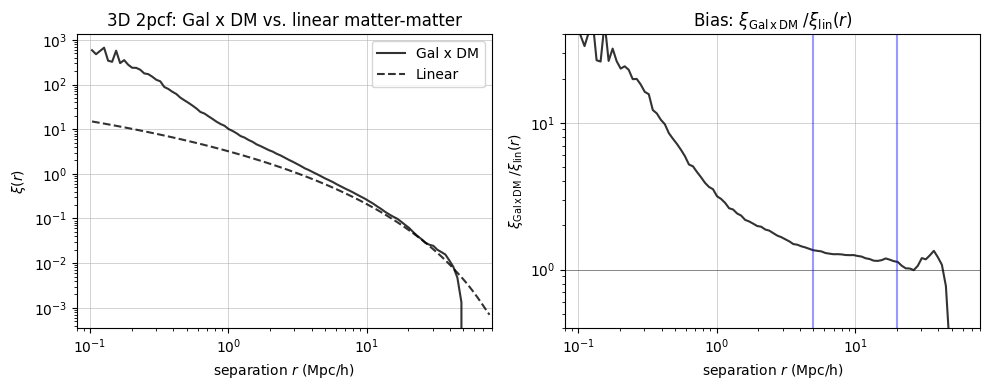

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(r, xix_spec, 'k-', alpha=0.8, label='Gal x DM')
axs[0].plot(r, xi_lin, 'k--', alpha=0.8, label='Linear')
axs[0].set_ylabel(r'$\xi(r)$')
axs[0].set_title('3D 2pcf: Gal x DM vs. linear matter-matter')
axs[0].legend()

axs[1].plot(r, ratio, 'k-', alpha=0.8)
axs[1].axhline(1., c='k', lw=0.5, alpha=0.5)
axs[1].axvline(rbounds[0].value, c='b', alpha=0.4)
axs[1].axvline(rbounds[1].value, c='b', alpha=0.4)
axs[1].set_ylim(0.4,40)
axs[1].set_ylabel(r'$\xi_\mathrm{Gal\, x\, DM}\ / \xi_\mathrm{lin}(r)$')
axs[1].set_title(r'Bias: $\xi_\mathrm{Gal\, x\, DM}\ / \xi_\mathrm{lin}(r)$')

for ax in axs:
    ax.set_xlim(0.08, 80)
    ax.grid(lw=0.5, alpha=0.8)
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.loglog()
fig.tight_layout()

In [11]:
# bias: average of a relatively flat range
idx = (rbounds[0] <= r) & (r <= rbounds[1])
bias = np.mean(ratio[idx])

In [12]:
bias

1.2328900891923191

In [13]:
def sigma_P_sq(k_, bias, redshift, V, nbar, cosmo=cosmology.setCosmology('planck15'), runit=u.Mpc/cu.littleh):
    k_ = k_.to(1/runit) if isinstance(k_, u.Quantity) else k_ << 1/runit
    V = V.to(runit**3) if isinstance(V, u.Quantity) else V << runit**3
    nbar = nbar.to(runit**(-3)) if isinstance(nbar, u.Quantity) else nbar << runit**(-3)
    P = cosmo.matterPowerSpectrum(k_.value, sim.redshift) << runit**3
    return 2 / V * (bias**2 * P + 1 / nbar)**2

In [14]:
V = sim.boxsize**3
nbar = len(gal_pos_spec)/V
sigma_P_sq_ = sigma_P_sq(k, bias, redshift, V, nbar)

Text(0.5, 1.0, '$\\sigma_P^2$: clustering + shot noise in 2pcf')

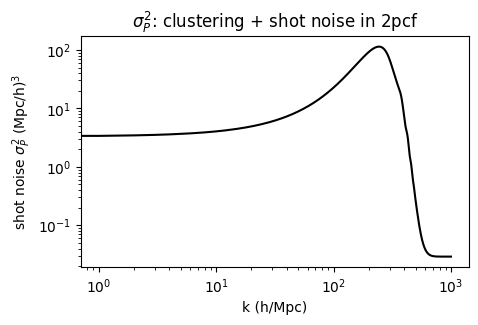

In [15]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(sigma_P_sq_, 'k-')
ax.loglog()
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('shot noise $\sigma_P^2$ (Mpc/h)$^3$')
ax.set_title(r'$\sigma_P^2$: clustering + shot noise in 2pcf')

### integrate

In [16]:
# only focus on the diagonal terms in the covariance, for now
def var(r, k, bias, nbar, sim):
    # multiplicative constant
    const = 1 / (2 * np.pi**2)
    
    redshift = sim.redshift
    V = sim.boxsize**3

    # function of k that we want to integrate
    def integrand(k):
        return k**2 * special.spherical_jn(0, (k * r).value)**2 * sigma_P_sq(k, bias, redshift, V, nbar)

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([integrand(k_).value for k_ in k]) << integrand(k[0]).unit  # shape (k,r)
    trapz = integrate.trapz(k_func_arr, x=k)

    return const*trapz

In [17]:
pred_var = np.array([
    var(r_, k, bias, nbar, sim).value for r_ in r
])

Text(0.5, 1.0, 'Predicted 2pcf uncertainty $\\sigma_\\xi(r)$')

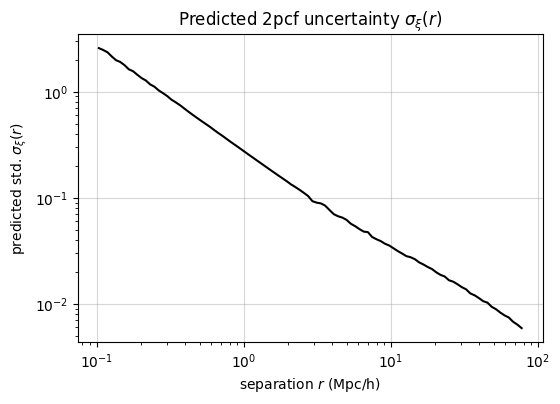

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(r, np.sqrt(pred_var), 'k-')
ax.loglog()
ax.grid(alpha=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'predicted std. $\sigma_\xi(r)$')
ax.set_title(r'Predicted 2pcf uncertainty $\sigma_\xi(r)$')

In [19]:
# random set
r1 = np.random.uniform(0, sim.boxsize.value, (len(gal_pos_spec),3)) << sim.boxsize.unit
# galaxy autocorrelation
ravg, xi_auto_spec = corrfuncs.xi_auto(d1, r1, r_edges << d1.unit, sim.boxsize)

In [20]:
idx = (xi_auto_spec > 1e-5)

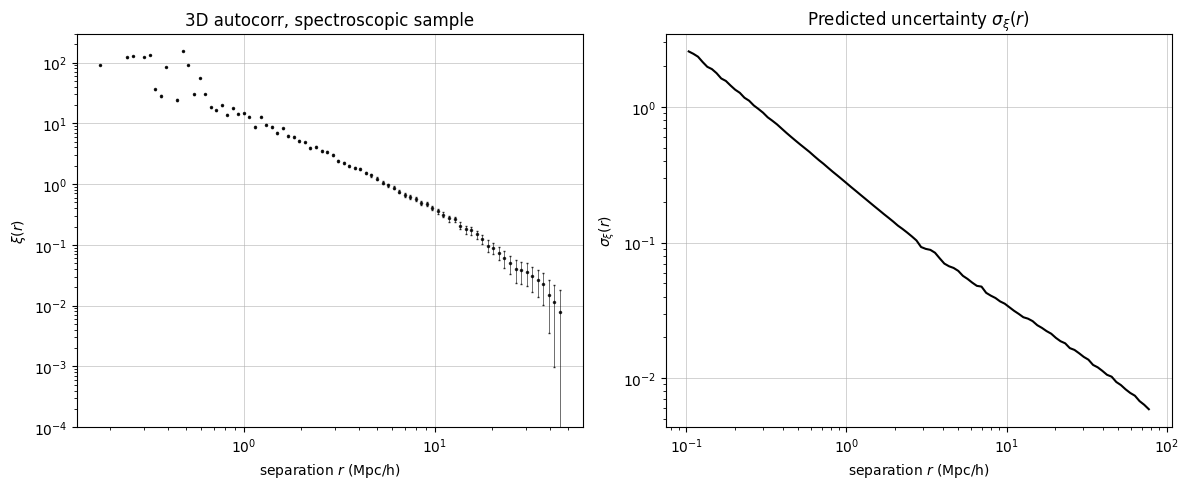

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].errorbar(r[idx], xi_auto_spec[idx], yerr=np.sqrt(pred_var[idx]), c='k', marker='.', ls='None', ms=3, lw=0.5, capsize=1, alpha=0.8)
axs[0].set_ylim(1e-4,3e2)
axs[0].set_ylabel(r'$\xi(r)$')
axs[0].set_title('3D autocorr, spectroscopic sample')

axs[1].plot(r, np.sqrt(pred_var), 'k-')
axs[1].set_ylabel(r'$\sigma_\xi(r)$')
axs[1].set_title(r'Predicted uncertainty $\sigma_\xi(r)$')

for ax in axs:
    ax.loglog()
    ax.grid(lw=0.5, alpha=0.8)
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
fig.tight_layout()

### covariance of the 2D 2pcf

Roman's equation:
$$
C_w(\theta_a,\theta_b)=\frac{2(2\pi)^3}{A_\Omega}\int_0^\infty k\,\mathrm{d}k\,[P(k)]^2\,J_0(k\theta_a)\,J_0(k\theta_b)
$$

From Adam, for the cross:
$$
C_w(w_x(\theta),w_x(\theta'))=\frac{2}{\Omega_\mathrm{sim}}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\,\ell\,J_0(\ell\theta)\,J_0(\ell\theta')\,\frac{1}{2}[C_x^2(\ell) + C_a(\ell)C_b(\ell)] ~,
$$
where $a$ and $b$ are the respective samples (e.g. galaxies and dark matter).

And we can approximate the linear angular power spectrum as
$$
C(\ell) \approx \frac{\Delta\chi}{\chi^2(\bar z)}\,W_\mathrm{phot}(\chi)\,W_i\,b_\mathrm{phot}(\bar z)\,b_i(\bar z) \,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$

Analogously, for the auto, the diagonal terms are
$$
C_w(\theta)=\frac{2}{\Omega_\mathrm{sim}}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\,\ell\,[J_0(\ell\theta)]^2\,C^2(\ell)
$$

and $C(\ell)$ is
$$
C(\ell) \approx \frac{\Delta\chi}{\chi^2(\bar z)}\,W_\mathrm{phot}(\chi)\,W_i\,b^2(\bar z)\,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$

In [ ]:
# C_ells
